# Import library

In [48]:
import os
import os, sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
pd.set_option("display.max_column", 100)

In [50]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

# Data load

In [107]:
max_babyid = 40000

df_train = pd.read_csv("data/df_train.csv")
df_train = df_train[df_train['baby_id'] < max_babyid]

df_test = pd.read_csv("data/df_test.csv")
df_test = df_test[df_test['baby_id'] < max_babyid]

print(df_train.shape, df_test.shape)
df_train.head()

(6137, 24) (1716, 24)


,baby_id,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,mask,gender,age_ratio,weekday,pcr_result
0,21099,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0.173322,0.007956,0.012987,1,0,0.18,3,0
1,21151,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.179024,0.008614,0.013084,1,0,0.17,4,0
2,21024,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.179024,0.008614,0.013084,1,1,0.29,4,0
3,20822,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.179024,0.008614,0.012138,1,0,0.51,4,0
4,21113,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.179024,0.008614,0.013084,1,0,0.40,4,0


In [108]:
import random
from sklearn.model_selection import train_test_split

print(df_train.shape)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1212)
print("Train:", df_train.shape, df_train['baby_id'].nunique())
print("Validaiton:", df_val.shape, df_val['baby_id'].nunique())

(6137, 24)
Train: (4909, 24) 3513
Validaiton: (1228, 24) 1097


## Remove baby_id and results

In [109]:
exclude_cols = ['baby_id', 'pcr_result']
cols = [x for x in df_train.columns if x not in exclude_cols]

df_train_gt = df_train[['pcr_result']]
df_train_input = df_train[cols]
df_val_gt = df_val[['pcr_result']]
df_val_input = df_val[cols]
df_test_gt = df_test[['pcr_result']]
df_test_input = df_test[cols]


In [110]:
# df_trainval = df_train.copy()
df_trainval = pd.concat([df_train, df_val], axis=0)
print(df_trainval.shape)


(6137, 24)


In [111]:
size_and_ratio(df_trainval, 'pcr_result')

Sum : 6137 (2,)


,size,ratio
pcr_result,,
1,4418,0.719896
0,1719,0.280104


In [112]:
size_and_ratio(df_test, 'pcr_result')

Sum : 1716 (2,)


,size,ratio
pcr_result,,
1,1346,0.784382
0,370,0.215618


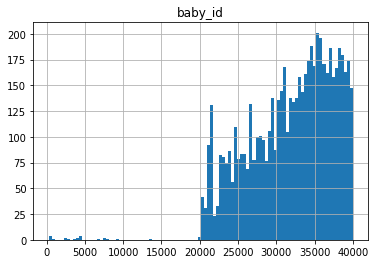

In [113]:
df_trainval.hist('baby_id', bins=100)
plt.show()

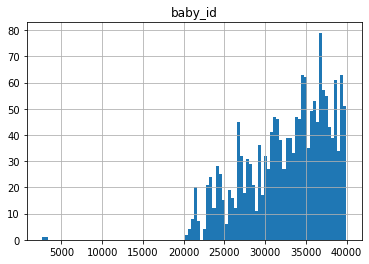

In [114]:
df_test.hist('baby_id',bins=100)
plt.show()

In [115]:
df_trainval['baby_id'].max()

39999

In [116]:
print(df_trainval['baby_id'].nunique(), df_test['baby_id'].nunique())

4159 1232


# Check Logistic regression performance

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def run_one_full_train_test(df_trainval, df_test, cols, model):
    x = df_trainval[cols]
    y = df_trainval['pcr_result']
    print(f"start to train: x.shape:{x.shape}, y.shape:{y.shape}")

    model.fit(x, y)
    print(f"Model: {model}")
    if getattr(model, 'predict_proba', False):
        print("Found predict_proba")
        pred_raw = model.predict_proba(df_trainval[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_trainval[cols])
    
    gt = df_trainval['pcr_result']

    print(pred_pos.shape, gt.shape)
    print("train set auc", roc_auc_score(gt, pred_pos))

    if getattr(model, 'predict_proba', False):
        pred_raw = model.predict_proba(df_test[cols])
        pred_pos = np.array([x[1] for x in pred_raw])
    else:
        pred_pos = model.predict(df_test[cols])
    
    gt = df_test['pcr_result']
    test_result = roc_auc_score(gt, pred_pos)
    print("test set auc", test_result)
        
    return model, test_result

lr_model = LogisticRegression()

run_one_full_train_test(df_trainval, df_test, cols, lr_model)

start to train: x.shape:(6137, 22), y.shape:(6137,)
Model: LogisticRegression()
Found predict_proba
(6137,) (6137,)
train set auc 0.8346367694062393
test set auc 0.7787157142283443


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(LogisticRegression(), 0.7787157142283443)

## repeat 5 times

In [118]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lr_model
    )

start to train: x.shape:(4909, 22), y.shape:(4909,)
Model: LogisticRegression()
Found predict_proba
(4909,) (4909,)
train set auc 0.8339556875651591
test set auc 0.7776555158427373
start to train: x.shape:(4909, 22), y.shape:(4909,)
Model: LogisticRegression()
Found predict_proba
(4909,) (4909,)
train set auc 0.8375940899638471
test set auc 0.7802317176017027
start to train: x.shape:(4909, 22), y.shape:(4909,)
Model: LogisticRegression()
Found predict_proba
(4909,) (4909,)
train set auc 0.8362211456255344
test set auc 0.7776896510180313
start to train: x.shape:(4909, 22), y.shape:(4909,)
Model: LogisticRegression()
Found predict_proba
(4909,) (4909,)
train set auc 0.8360980008083824
test set auc 0.7756254768884785
start to train: x.shape:(4909, 22), y.shape:(4909,)
Model: LogisticRegression()
Found predict_proba
(4909,) (4909,)
train set auc 0.834845564301087
test set auc 0.7781715593751255


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.7776555158427373, 1: 0.7802317176017027, 2: 0.7776896510180313, 3: 0.7756254768884785, 4: 0.7781715593751255}
mean: 0.7778747841452149 std: 0.0014686692516601156


### Use xgboost

In [106]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [65]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [66]:

run_one_full_train_test(df_trainval, df_test, cols, xg_reg)

start to train: x.shape:(12546, 22), y.shape:(12546,)
[10:05:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(12546,) (12546,)
train set 

(XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='reg:linear', ...),
 0.776696558536557)

In [41]:
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        xg_reg
    )

start to train: x.shape:(10372, 22), y.shape:(10372,)
[10:01:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', ...)
(10372,) (10372,)
train set 

In [42]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.777307852779551, 1: 0.7782255140745707, 2: 0.780313134086719, 3: 0.7782341320077171, 4: 0.7792733358771095}
mean: 0.7786707937651335 std: 0.0010302324351337776


### LGBM

In [43]:
import lightgbm as lgb

In [44]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
test_result = dict()
models = dict()
for i in range(5):
    models[i], test_result[i] = run_one_full_train_test(
        df_trainval.sample(int(df_trainval.shape[0]* 0.8), random_state=i), 
        df_test, cols,
        lgb_model
    )

start to train: x.shape:(10372, 22), y.shape:(10372,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(10372,) (10372,)
train set auc 0.9253358412165692
test set auc 0.8228387709519784
start to train: x.shape:(10372, 22), y.shape:(10372,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(10372,) (10372,)
train set auc 0.925341153145737
test set auc 0.8260826798562648
start to train: x.shape:(10372, 22), y.shape:(10372,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(10372,) (10372,)
train set auc 0.926773477952284
test set auc 0.8278591627648232
start to train: x.shape:(10372, 22), y.shape:(10372,)
Model: LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
Found predict_proba
(10372,) (10372,)
train set auc 0.9250399154826365
test set auc 0.8227184170580397
start to train: x.shape:(10372, 22), y.shape:(10372,)
Model: LGBMClassifier(learni

In [45]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))


{0: 0.8228387709519784, 1: 0.8260826798562648, 2: 0.8278591627648232, 3: 0.8227184170580397, 4: 0.8329077857379744}
mean: 0.826481363273816 std: 0.003762563717430573


## TabNet

In [46]:
import pandas as pd
import numpy  as np
from tqdm.auto import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import torch

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


start to train: x_train.shape:(10372, 22), y_train.shape:(10372,)
start to train: x_val.shape:(2593, 22), y_val.shape:(2593,)
y_train mean:0.7486502121095256. y_val mean:0.7365985345160047
epoch 0  | loss: 0.61708 | train_auc: 0.52023 | valid_auc: 0.50836 |  0:00:01s
epoch 2  | loss: 0.44796 | train_auc: 0.72802 | valid_auc: 0.73309 |  0:00:03s
epoch 4  | loss: 0.42956 | train_auc: 0.78467 | valid_auc: 0.78796 |  0:00:04s
epoch 6  | loss: 0.41121 | train_auc: 0.80725 | valid_auc: 0.7985  |  0:00:06s
epoch 8  | loss: 0.40484 | train_auc: 0.82496 | valid_auc: 0.81729 |  0:00:08s
epoch 10 | loss: 0.40117 | train_auc: 0.81157 | valid_auc: 0.81161 |  0:00:10s
epoch 12 | loss: 0.40014 | train_auc: 0.82981 | valid_auc: 0.8269  |  0:00:12s
epoch 14 | loss: 0.39696 | train_auc: 0.83447 | valid_auc: 0.82722 |  0:00:14s
epoch 16 | loss: 0.39573 | train_auc: 0.83732 | valid_auc: 0.82684 |  0:00:16s
epoch 18 | loss: 0.39752 | train_auc: 0.83938 | valid_auc: 0.82956 |  0:00:18s
epoch 20 | loss: 0.39

/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


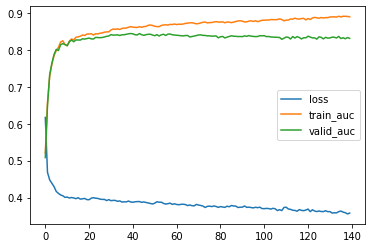

y_val.head:[0 0 1 1 1]
BEST AUC SCORE ON VALIDATION SET : 0.8445589599319294
start to test: x_test.shape:(3469, 22), y_test.shape:(3469,)


array([0.22761082, 0.06525877, 0.1554641 , 0.00049433, 0.02009045,
       0.11947101, 0.        , 0.01131381, 0.01980297, 0.0010189 ,
       0.11041201, 0.00546085, 0.01241436, 0.02093564, 0.05781961,
       0.01110555, 0.0957745 , 0.00292292, 0.0027982 , 0.02809324,
       0.02791163, 0.00382634])

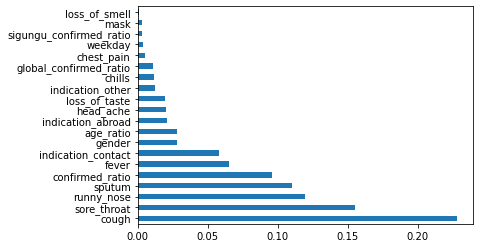

preds_test head:[[0.5772931  0.42270684]
 [0.7493811  0.25061896]
 [0.56479806 0.43520197]
 [0.56940687 0.4305931 ]
 [0.66409427 0.3359057 ]]
BEST AUC SCORE ON TEST SET : 0.7806801391707052
Best epoch:39
save_path ./train_data/TabNetClassifier_TabNet_DEFAULT_0039.pth
Successfully saved model at ./train_data/TabNetClassifier_TabNet_DEFAULT_0039.pth.zip
Success to save to :  ./train_data/TabNetClassifier_TabNet_DEFAULT_0039.pth
start to train: x_train.shape:(10372, 22), y_train.shape:(10372,)
start to train: x_val.shape:(2593, 22), y_val.shape:(2593,)
y_train mean:0.7433474739683764. y_val mean:0.7578094870806016


/Users/mckim/miniconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62055 | train_auc: 0.56695 | valid_auc: 0.55419 |  0:00:00s
epoch 2  | loss: 0.46086 | train_auc: 0.67944 | valid_auc: 0.68225 |  0:00:02s
epoch 4  | loss: 0.44193 | train_auc: 0.75651 | valid_auc: 0.77356 |  0:00:04s
epoch 6  | loss: 0.4282  | train_auc: 0.76506 | valid_auc: 0.77623 |  0:00:06s
epoch 8  | loss: 0.41754 | train_auc: 0.79361 | valid_auc: 0.80082 |  0:00:08s


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [47]:
def run_one_full_train_test_with_tabnet(df_trainval, df_test, cols, model):
    df_train, df_val = train_test_split(df_trainval, test_size=0.2)
    x_train = df_train[cols].to_numpy()
    y_train = df_train['pcr_result'].to_numpy()
    x_val = df_val[cols].to_numpy()
    y_val = df_val['pcr_result'].to_numpy()
    x_test = df_test[cols].to_numpy()
    y_test = df_test['pcr_result'].to_numpy()

    print(f"start to train: x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}")
    print(f"start to train: x_val.shape:{x_val.shape}, y_val.shape:{y_val.shape}")
    print(f"y_train mean:{np.mean(y_train)}. y_val mean:{np.mean(y_val)}")

    model.fit(
        X_train=x_train, y_train=y_train,
        eval_set=[(x_train, y_train), (x_val, y_val)],
        eval_name=['train', 'valid'],
#         patience=2, 
#         max_epochs=100,
        patience=100, 
        max_epochs=1000,
        eval_metric=['auc'],
    )
    
    print(f"Model: {model}")
    # plot losses
    plt.plot(model.history['loss'], label='loss')

    # plot accuracy
    plt.plot(model.history['train_auc'], label='train_auc')
    plt.plot(model.history['valid_auc'], label='valid_auc')
    plt.legend(['loss', 'train_auc', 'valid_auc'])
    plt.show()
    plt.clf()

    # determine best accuracy for validation set
    preds_valid = model.predict_proba(x_val)
    print(f"y_val.head:{y_val[:5]}")
    pred_pos = np.array([x[1] for x in preds_valid])
    valid_auc = roc_auc_score(y_val, pred_pos)
    print(f"BEST AUC SCORE ON VALIDATION SET : {valid_auc}")
    
    print(f"start to test: x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}")
    # find and plot feature importance
    y_pred = model.predict(x_test)
    feature_importances_ = model.feature_importances_
    display(feature_importances_)
    feat_importances = pd.Series(model.feature_importances_, index=cols)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    plt.clf()

    # determine best accuracy for test set
    preds = model.predict_proba(x_test)
    pred_pos = np.array([x[1] for x in preds])
    test_auc = roc_auc_score(y_test, pred_pos)
    print(f"preds_test head:{preds[:5]}")
    print(f"BEST AUC SCORE ON TEST SET : {test_auc}")
    
    config_name = 'TabNet_DEFAULT'
    best_epoch, element = max(enumerate(model.history['valid_auc']), key=lambda x: x[1])
    print(f"Best epoch:{best_epoch}")
    best_model = save_model(config_name, model, best_epoch)
    
    return model, test_auc

def save_model(config_name, model, epoch):
    save_path = f"./train_data/{model.__class__.__name__}_{config_name}_{epoch:04d}.pth"
    print("save_path", save_path)
    model.save_model(save_path)
    print("Success to save to : ", save_path)
    return model


test_result = dict()
models = dict()
for i in range(5):
    tab_model = TabNetClassifier(verbose = 2,seed = 1212)
    models[i], test_result[i] = run_one_full_train_test_with_tabnet(
        df_trainval, 
        df_test, cols,
        tab_model
    )
    

In [ ]:
print(test_result)
print("mean:", np.mean(list(test_result.values())), "std:", np.std(list(test_result.values())))
